Author: Hem N Chaudhary

Date: Jan, 2024

Description: Multilingual Named Entity Recognition

In [ ]:
!pip install datasets

In [ ]:
# getting config info about datasets

from datasets import get_dataset_config_names

xtreme_subsets=get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


XTREME has 183 configurations


In [ ]:
#searching for configuration starting with "PAN"
panx_subsets= [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [ ]:
#importing german corpus
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [ ]:
#To track each language, creating Python defultdict, stores language codes as the key and PAN-X corpus of type DatasetDict as Value

from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

#return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  #Load monolingual corpus
  ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
  #shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (ds[split].shuffle(seed=42).select(range(int(frac*ds[split].num_rows))))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for xtreme contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xtreme
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
#checking # example per language

import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:
#inspecting one the example in the German corpus

element = panx_ch["de"]["train"][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['Olympique', 'Nîmes', ',', 'Auxerres', 'seinerzeitiger', 'drittklassiger', 'Endspielgegner', ',', 'hatte', 'sich', 'erst', 'gar', 'nicht', 'für', 'die', 'Hauptrunde', 'qualifizieren', 'können', '.']
ner_tags: [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [ ]:
#decrypting ner_tags

for key, value in panx_ch["de"]["train"].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [ ]:
#picking out the ClassLabel for ner_tags

tags=panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [ ]:
#new columns in training set with class names for each tag

def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de=panx_ch["de"].map(create_tag_names)

In [ ]:
#visualize the above processing

de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Tokens,Olympique,Nîmes,",",Auxerres,seinerzeitiger,drittklassiger,Endspielgegner,",",hatte,sich,erst,gar,nicht,für,die,Hauptrunde,qualifizieren,können,.
Tags,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


In [ ]:
#calculating freq of each entity across entity for unusual imbalance

from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type=tag.split("-")[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")


,ORG,PER,LOC
train,5397,5881,6169
validation,2639,2870,3172
test,2657,2971,3100


In [ ]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [ ]:
text = "Jack Sparrow loves New York!"
bert_tokens= bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(f"BERT: {bert_tokens}")
print(f"XLM-R: {xlmr_tokens}")

BERT: ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
XLM-R: ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [ ]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

**Creating Custom Model for Token Classification**

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    #Load Model Body
    self.roberta = RobertaModel(config, add_pooling_layer = False)
    #set up token classification head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    #Load and initialize weights
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    #Use model body to get encoder representations
    outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
    #Apply classifier to encoder representation
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    #Calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


**Loading a Custom Model**

In [ ]:
#tags for each entity and the mapping of each tags to an ID and vice-v.
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
#storing the mappings and tags.num_classes in config
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         idx2label=index2tag,
                                         label2id=tag2index)

In [ ]:
#loading the model with additional config arguments
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#quick check to test initialization of token and model

input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
#passing the input, and extracting the predictions by argmax

outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=2)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")
print(predictions)

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')


In [ ]:
#prediction from the logits

preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER


In [ ]:
#wrapping the preceding steps into a helper function

def tag_text(text, tags, model, tokenizer):
  #Get tokens with special characters
  tokens = tokenizer(text).tokens()
  #Encode the sequence into IDs
  input_ids = tokenizer.encode(text, return_tensors="pt")
  #Get predictions as distribution over 7 possible classes
  outputs = model(input_ids.to(device)).logits
  #Take argmax to get most likely class per token
  predictions=torch.argmax(outputs, dim=-1)
  #convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

**Tokenizing Texts for NER**

In [ ]:
#visualizing tokenization
words, labels =de_example["tokens"], de_example["ner_tags"]

In [ ]:
#tokenize each words and use is_split_into_words
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
Tokens,<s>,▁Olymp,ique,▁N,îm,es,▁,",",▁Au,xer,...,▁die,▁Haupt,runde,▁quali,fi,zieren,▁können,▁,.,</s>


In [ ]:
#masking subword representations
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
Tokens,<s>,▁Olymp,ique,▁N,îm,es,▁,",",▁Au,xer,...,▁die,▁Haupt,runde,▁quali,fi,zieren,▁können,▁,.,</s>
Word IDs,None,0,0,1,1,1,2,2,3,3,...,14,15,15,16,16,16,17,18,18,None


In [ ]:
#setting -100 as the label for these special tokens and the subwords
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

labels=[]
for l in label_ids:
  if l != -100:
    labels.append(index2tag[l])
  else:
    labels.append("IGN")

index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
Tokens,<s>,▁Olymp,ique,▁N,îm,es,▁,",",▁Au,xer,...,▁die,▁Haupt,runde,▁quali,fi,zieren,▁können,▁,.,</s>
Word IDs,None,0,0,1,1,1,2,2,3,3,...,14,15,15,16,16,16,17,18,18,None
Label IDs,-100,3,-100,4,-100,-100,0,-100,0,-100,...,0,0,-100,0,-100,-100,0,0,-100,-100
Labels,IGN,B-ORG,IGN,I-ORG,IGN,IGN,O,IGN,O,IGN,...,O,O,IGN,O,IGN,IGN,O,O,IGN,IGN


In [ ]:
# putting all the previous work in one function

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs



In [ ]:
#writing a code to iterate over the datasets

def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True, remove_columns = ['langs', 'ner_tags', 'tokens'])

In [ ]:
#trying out the functions

panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

**Performance Measures**

In [ ]:
! pip install seqeval

In [ ]:
#sequeval for measures like precision, recall, and F1-score

from seqeval.metrics import classification_report

y_true = [ ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
              ["B-PER", "I-PER", "O"]]
y_pred = [ ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
              ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
# customizing outputs to match seqeval format

import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      #Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list



**Fine_tuning XLM-RoBERTa **

In [ ]:
#!pip uninstall accelerate
#!pip uninstall transformers
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-z6ig714k
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-z6ig714k
  Resolved https://github.com/huggingface/accelerate to commit 31fd2b1ad6b9c1cd1480568399a311b3caaf62dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import accelerate
import transformers

print("accelerate version:", accelerate.__version__)
print("transformers version:", transformers.__version__)

accelerate version: 0.27.0.dev0
transformers version: 4.36.2


In [ ]:
from transformers import TrainingArguments

num_epochs = 3
batch_size =24
logging_steps = len(panx_de_encoded["train"])// batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir = model_name, log_level = "error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

In [ ]:
from google.colab import userdata
key=userdata.get('huggingface')

In [ ]:
from huggingface_hub import login
login(token=key, write_permission=True )

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# instructing trainer to calculate f1_score

from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

In [ ]:
#defining data collator so that we can pad each input sequence to the largest sequence length in a batch

from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
#using model_init() to initialize many models through out the colab

def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [ ]:
#passing all this information together with encoded datasets to the trainer

from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [ ]:
#the trigger line
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.262100,0.162563,0.814303
2,0.127000,0.128147,0.860389
3,0.081500,0.128196,0.864896


TrainOutput(global_step=1575, training_loss=0.15666493264455644, metrics={'train_runtime': 486.8133, 'train_samples_per_second': 77.525, 'train_steps_per_second': 3.235, 'total_flos': 852598822433688.0, 'train_loss': 0.15666493264455644, 'epoch': 3.0})

In [ ]:
#trainer.push_to_hub(commit_message="Training Completed!")

In [ ]:
#test the new model

text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


**Error Analysis**

In [ ]:
#calculating a loss per token

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  #Convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  #Pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    #pass data through model
    outputs = trainer.model(input_ids, attention_mask)
    #logit.size: [batch_size, sequence_length, classes]
    #predict class with largest logit value on classses axis
    predicted_label = torch.argmax(outputs.logits, axis=-1).cpu().numpy()
  #Calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(outputs.logits.view(-1,7), labels.view(-1), reduction="none")
  #Unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss": loss, "predicted_label": predicted_label}

In [ ]:
#applying to whole validation set using map()

valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
#token and labels to string
index2tag[-100]="IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["loss"] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1
)
df["predicted_label"] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1
)

df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 13015, 5, 18431, 93, 334, 2819, 12535, 111...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, IGN, IGN, IGN, IGN, O, B-ORG, I-ORG, ...","[0.0, 0.008445146, 0.0, 0.0, 0.0, 0.0, 0.00075...","[I-ORG, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG,...","[<s>, ▁Hon, ., DU, ni, v, ▁;, ▁University, ▁of..."
1,"[0, 242, 5106, 140546, 4880, 910, 5106, 242, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, IGN, O, O, O, B-LOC, IGN, IG...","[0.0, 0.00017653337, 0.00017260015, 0.00073227...","[B-LOC, O, O, O, O, O, O, O, O, B-LOC, B-LOC, ...","[<s>, ▁', ▁'', ▁254, ▁06, 6, ▁'', ▁', ▁in, ▁He..."
2,"[0, 6, 162994, 921, 47969, 122, 61351, 9, 284,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, O, B-ORG, I-ORG, I-ORG, IGN, IGN...","[0.0, 0.0004735064, 0.0, 0.0005239068, 0.46568...","[I-LOC, O, O, O, B-ORG, I-LOC, I-LOC, I-LOC, I...","[<s>, ▁, siehe, ▁auch, ▁Liste, ▁der, ▁Kategori..."
3,"[0, 16459, 242, 5106, 91281, 18917, 219167, 51...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, I-LOC, O, O, IGN]","[0.0, 0.0001982254, 0.00019691436, 0.000218844...","[B-LOC, O, O, O, B-LOC, I-LOC, I-LOC, O, O, B-...","[<s>, ▁**, ▁', ▁'', ▁Graf, schaft, ▁Toulouse, ..."
4,"[0, 165743, 9, 42378, 428, 191, 40180, 266, 46...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, IGN, IGN, IGN, I-ORG, IGN, O...","[0.0, 0.37530208, 0.0, 0.0, 0.0, 0.0, 0.162653...","[O, B-ORG, O, O, I-ORG, I-ORG, I-ORG, I-ORG, O...","[<s>, ▁Zentral, -, Sta, di, on, ▁Batu, mi, ▁–,..."


In [ ]:
#unpacking the lists in each cells

df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,13015,1,O,0.01,O,▁Hon
0,2819,1,O,0.00,O,▁;
0,12535,1,B-ORG,0.00,B-ORG,▁University
0,111,1,I-ORG,0.00,I-ORG,▁of
0,8620,1,I-ORG,0.00,I-ORG,▁Kwa


In [ ]:
#grouping by input tokens and aggregate the losses for each token with the count, mean and sum

(df_tokens.groupby("input_tokens")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1).sort_values(by="sum",ascending=False).reset_index().round(2).head(10).T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁/,▁der,▁von,▁(,▁),▁in,▁und,▁des,▁D
count,5967,160,1355,796,246,246,990,1140,342,68
mean,0.02,0.63,0.07,0.11,0.34,0.3,0.07,0.06,0.12,0.56
sum,125.76,100.79,97.75,85.16,83.73,73.56,67.14,64.74,40.76,38.32


In [ ]:
#grouping the label IDs
(df_tokens.groupby("labels")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1).sort_values(by="mean", ascending=False).reset_index().round(2).T)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1447,2639,3774,3172,2870,4140,43122
mean,0.62,0.61,0.44,0.37,0.25,0.18,0.02
sum,895.23,1622.79,1662.92,1168.62,703.23,724.67,1017.94


In [ ]:
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()



In [ ]:
import matplotlib.pyplot as plt

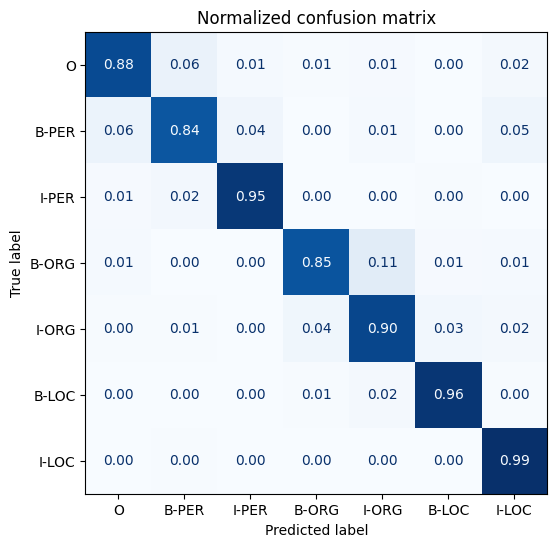

In [ ]:
plot_confusion_matrix(df_tokens["labels"],df_tokens["predicted_label"],tags.names)

In [ ]:
#looking sequences with high losses
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention_mask"]):
      if i not in {0, len(row["attention_mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T

    yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
  display(sample)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
tokens,▁Schwa,n,dorf,▁–,▁Cham,▁–,▁Fur,th,▁im,▁Wald,...,▁als,▁Teil,▁der,▁Fern,verbindung,▁München,▁-,▁Prag,▁),</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,...,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN
preds,B-LOC,I-LOC,I-LOC,O,B-LOC,O,B-LOC,I-LOC,I-LOC,I-LOC,...,O,O,O,O,O,B-LOC,O,B-LOC,I-LOC,O
losses,4.35,0.00,0.00,6.37,7.55,6.67,8.02,0.00,5.04,5.13,...,3.03,5.99,6.52,5.45,0.00,1.74,2.36,3.62,1.52,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.49,0.00,0.00,7.15,8.59,8.92,5.91,0.00,8.08,8.99,7.73,6.27,4.74,0.00,0.00,0.03,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁1988,▁in,▁Auckland,▁und,▁1989,▁in,▁Stavanger,▁tru,g,▁er,▁mit,▁einem,▁sie,b,ten,▁bzw,▁,.,</s>
labels,B-ORG,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,IGN,O,O,O,O,IGN,IGN,O,O,IGN,IGN
preds,O,O,B-LOC,O,O,O,B-LOC,O,O,O,O,O,O,O,O,O,O,O,O
losses,5.15,9.51,8.39,0.00,5.44,9.07,8.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
#example with parenthesis and and slashes
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9
tokens,▁German,▁Master,s,▁(,▁S,no,ok,er,▁),</s>
labels,B-PER,I-PER,IGN,I-PER,I-PER,IGN,IGN,IGN,I-PER,IGN
preds,B-PER,I-ORG,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER
losses,0.39,0.74,0.00,0.59,0.38,0.00,0.00,0.00,0.33,0.00


,0,1,2,3,4,5,6
tokens,▁Drag,e,▁(,▁El,be,▁),</s>
labels,B-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.01,0.00,0.01,0.01,0.00,0.01,0.00


**Cross-Lingual Transfer**

In [ ]:
#predict() method to evaluate on multiple language
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
#examine performance on test set and keeping track of them on dict
f1_scores = defaultdict(dict)
f1_scores['de']['de'] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.862


In [ ]:
#testing on french
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,I-LOC,O


In [ ]:
#testing on whole set of french
def evaluate_lang_performance(lang,trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds["test"])

In [ ]:
f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.709


In [ ]:
#testing on Italian
f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.683


In [ ]:
#testing on English
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.583


**When does Zero-Shot Transfer make sense?**

In [ ]:
#Finetuning XLM-R on increasing size of dataset on French

def train_on_subset(dataset, num_samples):
  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]
  training_args.logging_steps = len(train_ds)//batch_size

  trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator,
                    compute_metrics=compute_metrics, train_dataset=train_ds, eval_dataset=valid_ds,
                    tokenizer=xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message="Training Completed!")

  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict({
      "num_samples": [len(train_ds)], "f1_score": [f1_score]
  })

In [ ]:
#encoding the French corpus into input IDs, attention masks, lable IDs
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [ ]:
#check if function works on 250 example of trainig set
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.592800,1.212986,0.005136
2,1.120000,0.871592,0.415016
3,0.875600,0.746074,0.485770


,num_samples,f1_score
0,250,0.472344


In [ ]:
#increasing the raining set sizes to 500, 1000, 2000, 4000
for num_samples in [500, 1000, 2000, 4000]:
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,1.350900,0.841857,0.457990
2,0.753300,0.546585,0.619697
3,0.535700,0.483511,0.670815


<ipython-input-74-c684d3dc2e74>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,1.026100,0.477322,0.677618
2,0.428600,0.394201,0.728407
3,0.344400,0.349242,0.752189


<ipython-input-74-c684d3dc2e74>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,0.773800,0.449946,0.661671
2,0.346300,0.302294,0.797633
3,0.226600,0.295563,0.811402


<ipython-input-74-c684d3dc2e74>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,0.568800,0.293066,0.794258
2,0.257600,0.258729,0.813230
3,0.172800,0.253868,0.847728


<ipython-input-74-c684d3dc2e74>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


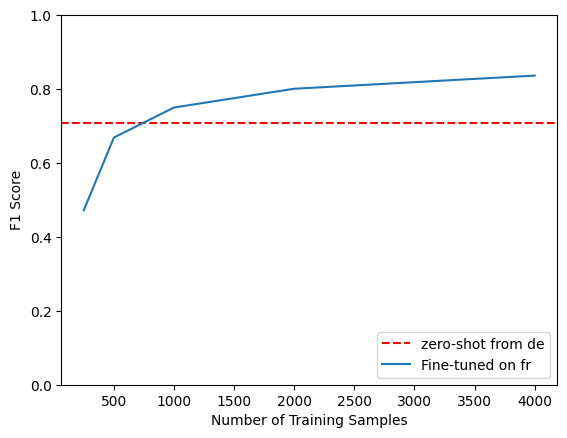

In [ ]:
#comparing on french compares to zero-shot cross-lingual transfer from german
fig, ax = plt.subplots()
ax.axhline(f1_scores['de']['fr'], ls='--', color='r')
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["zero-shot from de", 'Fine-tuned on fr'], loc="lower right")
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

**Fine-Tuning on Multiple Languages at Once**

In [ ]:
# concatenating German and French

from datasets import concatenate_datasets

def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]).shuffle(seed=42)
  return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
#using same hyperparameters as before

training_args.logging_steps = len(panx_de_fr_encoded["train"])//batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlmr-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator,
                  compute_metrics=compute_metrics, tokenizer=xlmr_tokenizer,
                  train_dataset=panx_de_fr_encoded["train"], eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.275200,0.176280,0.813093
2,0.144000,0.151503,0.857328
3,0.089500,0.153547,0.867398


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hndc/xlmr-roberta-base-finetuned-panx-de-fr/commit/db77305eca2852139671cea264ff00bf8cdecd5c', commit_message='Training completed!', commit_description='', oid='db77305eca2852139671cea264ff00bf8cdecd5c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
#Model performance on the test set of each language

for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer)
  print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de] dataset: 0.868


F1-score of [de-fr] model on [fr] dataset: 0.858


F1-score of [de-fr] model on [it] dataset: 0.801


F1-score of [de-fr] model on [en] dataset: 0.678


In [ ]:
# comparision of fine-tuning on each language separatly against multilingual learning

corpora = [panx_de_encoded]

#Exclude German from iteration

for lang in langs[1:]:
  training_args.output_dir = f"xlmr-roberta-base-finetuned-panx-{lang}"
  #Fine-tune on monolingual corpus
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  #Collect F1-scores in common dict
  f1_scores[lang][lang] = metrics["f1_score"][0]
  corpora.append(ds_encoded)


Epoch,Training Loss,Validation Loss,F1
1,0.558100,0.329262,0.781878
2,0.254300,0.252932,0.841125
3,0.161100,0.249951,0.844925


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,0.688700,0.383950,0.698517
2,0.275000,0.288937,0.767668
3,0.183200,0.297446,0.793515


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,0.933400,0.508721,0.574807
2,0.466600,0.418860,0.635294
3,0.339900,0.411310,0.679829


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

In [ ]:
#concatitating all four languages
corpora_encoded = concatenate_splits(corpora)


In [ ]:
#running trainer with multilingual datasets
training_args.logging_steps = len(corpora_encoded["train"])//batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"], eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.286900,0.191886,0.811863
2,0.150500,0.161857,0.845483
3,0.096100,0.169202,0.862461


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/hndc/xlm-roberta-base-finetuned-panx-all/commit/91aa5a25c229df5ee81f5268c9e178cb49724b1f', commit_message='Training completed!', commit_description='', oid='91aa5a25c229df5ee81f5268c9e178cb49724b1f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
#generating predictions from trainer on each language's test

for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

scores_data = {'de': f1_scores['de'],
               'each': {lang: f1_scores[lang][lang] for lang in langs},
               'all': f1_scores['all']}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)

f1_scores_df.rename_axis(index='Fine-tune on', columns='Evaluated on', inplace=True)

f1_scores_df




Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8625,0.7091,0.6831,0.5829
each,0.8625,0.8387,0.8039,0.7162
all,0.8656,0.8657,0.8576,0.7631
